<a href="https://colab.research.google.com/github/arjasc5231/moodots/blob/ACRNN/SER/CNN/makeSpectrogram3D_emoDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt 
import sklearn as sk

In [ ]:
label = {'W':0, 'L':1, 'E':2, 'A':3, 'F':4, 'T':5, 'N':6} # anger,boredom,disgust,fear,happiness,sadness,neutral

In [ ]:
A = np.array([[[[1,11],[2,22],[3,33]],[[4,44],[5,55],[6,66]]],[[[7,77],[8,88],[9,99]],[[10,100],[11,110],[12,120]]]])
print(A.shape)
print(A)
B = np.reshape(A,(-1,3,2))
print(B.shape)
print(B)
mean = np.mean(B,axis=0)
print(mean.shape)
print(mean)
C = B-mean
print(C.shape)
print(C)
print(C.reshape(2,2,3,2))

(2, 2, 3, 2)
[[[[  1  11]
   [  2  22]
   [  3  33]]

  [[  4  44]
   [  5  55]
   [  6  66]]]


 [[[  7  77]
   [  8  88]
   [  9  99]]

  [[ 10 100]
   [ 11 110]
   [ 12 120]]]]
(4, 3, 2)
[[[  1  11]
  [  2  22]
  [  3  33]]

 [[  4  44]
  [  5  55]
  [  6  66]]

 [[  7  77]
  [  8  88]
  [  9  99]]

 [[ 10 100]
  [ 11 110]
  [ 12 120]]]
(3, 2)
[[ 5.5  58.  ]
 [ 6.5  68.75]
 [ 7.5  79.5 ]]
(4, 3, 2)
[[[ -4.5  -47.  ]
  [ -4.5  -46.75]
  [ -4.5  -46.5 ]]

 [[ -1.5  -14.  ]
  [ -1.5  -13.75]
  [ -1.5  -13.5 ]]

 [[  1.5   19.  ]
  [  1.5   19.25]
  [  1.5   19.5 ]]

 [[  4.5   42.  ]
  [  4.5   41.25]
  [  4.5   40.5 ]]]
[[[[ -4.5  -47.  ]
   [ -4.5  -46.75]
   [ -4.5  -46.5 ]]

  [[ -1.5  -14.  ]
   [ -1.5  -13.75]
   [ -1.5  -13.5 ]]]


 [[[  1.5   19.  ]
   [  1.5   19.25]
   [  1.5   19.5 ]]

  [[  4.5   42.  ]
   [  4.5   41.25]
   [  4.5   40.5 ]]]]


(911, 128, 128, 3)
(911, 128, 128, 3)
(911,)


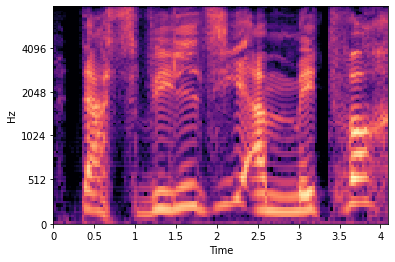

In [ ]:
# 1음성->n데이터
scaler = sk.preprocessing.MinMaxScaler()
mel_X = []
mel_Y = []
root = '/content/drive/MyDrive/team_runner/colab/dataset/emoDB/wave/'

for file in os.listdir(root):
    y, sr = librosa.load(root+file,sr=None)
    y_label = label[file[5]]
    n_fft = int(sr*0.025)
    hop_length = int(sr*0.01)

    for i in range(0,len(y),20400):
      if i+20400>len(y): continue
      yy = y[i:i+20400]  
      
      mel = librosa.power_to_db(librosa.feature.melspectrogram(y=yy, sr=sr, n_fft=n_fft, hop_length=hop_length)) # -> 128*128 (f,t)
      delta1 = librosa.feature.delta(data=mel, width=5)
      delta2 = librosa.feature.delta(data=delta1, width=5)

      mel_X.append(np.dstack((mel,delta1,delta2))) # -> (i,f,t,ch)
      mel_Y.append(y_label)
        
mel_X = np.array(mel_X)
librosa.display.specshow(mel_X[0,:,:,0], x_axis='time', y_axis='mel', sr=sr)
print(mel_X.shape)
mel_Y = np.array(mel_Y)

mel_X = mel_X.swapaxes(1, 2)  # -> (i,t,f,ch)
i,t,f,ch = mel_X.shape
mel_X = mel_X.reshape(i*t,f,ch)
mean = mel_X.mean(axis=0)
std = mel_X.std(axis=0)
mel_X = (mel_X-mean)/std
mel_X = mel_X.reshape(i,t,f,ch)
mel_X = mel_X.swapaxes(1, 2)

print(mel_X.shape)
print(mel_Y.shape)
# 10분정도 걸린듯

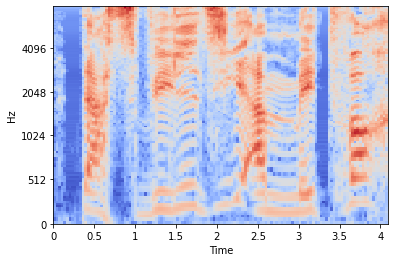

In [ ]:
librosa.display.specshow(mel_X[0,:,:,0], x_axis='time', y_axis='mel', sr=sr)

In [ ]:
# label별 개수
num = [0]*7
for i in mel_Y: num[i]+=1
for i in range(7): print(['anger','boredom','disgust','fear','happiness','sadness','neutral'][i]+'\t\t'+str(num[i]))

anger		202
boredom		137
disgust		97
fear		93
happiness		106
sadness		167
neutral		109


In [ ]:
shuffle_idx = np.arange(mel_X.shape[0])
np.random.shuffle(shuffle_idx)

mel_X = mel_X[shuffle_idx]
mel_Y = mel_Y[shuffle_idx]

In [ ]:
mel_X_train, mel_X_test, mel_Y_train, mel_Y_test = sk.model_selection.train_test_split(mel_X,mel_Y)
mel_XY = (mel_X_train, mel_X_test, mel_Y_train, mel_Y_test)
np.save("./emo_mel_3d.npy", mel_XY)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
